# D1V3 sodtube

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/li-positive-one/bte-pytorch/blob/main/docs/notebooks/D1V1_BGK.ipynb)

In [1]:
!pip install -U bte-pytorch

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import sys
import os
import torch
import math
from tqdm import tqdm
from bte.dvm import solver as bgk_solver
from matplotlib import pyplot as plt
import torch
torch.set_default_dtype(torch.float64)

kn = 1
rho_l, u_l, P_l = 1.0, 0., 1
rho_r, u_r, P_r = 0.125, 0., 0.1
T_l=P_l/rho_l
T_r=P_r/rho_r

nx=200
vmax=10

rho_l=rho_l*torch.ones(nx,1)
u_l=u_l*torch.ones(nx,3)
T_l=T_l*torch.ones(nx,1)
rho_r=rho_r*torch.ones(nx,1)
u_r=u_r*torch.ones(nx,3)
T_r=T_r*torch.ones(nx,1)

def maxwellian(v, rho, u, T):
    return (rho / torch.sqrt(2 * math.pi * T)**v.shape[-1]) * torch.exp(-((u[..., None, :] - v) ** 2).sum(dim=-1) / (2 * T))
        
f0_l = lambda v: maxwellian(v, rho_l, u_l, T_l)
f0_r = lambda v: maxwellian(v, rho_r, u_r, T_r)

solver = bgk_solver.BGKSolver(-0.5,0.5,nx,(-vmax,-vmax,-vmax),(vmax,vmax,vmax),(200,40,40),device='cuda')
solver.set_space_order(2)
solver.set_time_stepper("bgk-RK2")
x, v = solver.dis.x.cpu(), solver.dis.v.cpu()
f0 = f0_l(v) * (x < 0)[:, None] + f0_r(v) * (x >= 0)[:, None]
f0 = f0.unsqueeze(0).repeat(1, 1, 1).cuda()
solver.cuda()
print("f0.shape:", f0.shape)
solver.set_initial(kn, f0)
solver.dis.dx=solver.dis.dx.cuda()

torch.Size([200, 40, 40, 3])
f0.shape: torch.Size([1, 200, 320000])


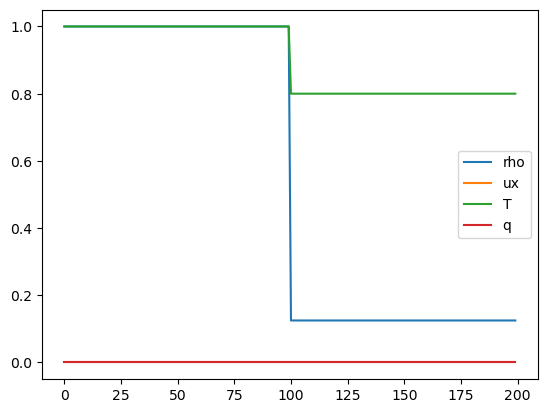

In [3]:
plt.plot(solver.dis.density().cpu()[0,:,0],label='rho')
plt.plot(solver.dis.velocity().cpu()[0,:,0],label='ux')
plt.plot(solver.dis.temperature().cpu()[0,:,0],label='T')
plt.plot(solver.dis.heatflux().cpu()[0,:,0],label='q')
plt.legend()
plt.show()

In [4]:
# solve
t_final, dt = 0.1, 0.001
CFL = 0.45
max_dt = CFL * 1.0 / nx / vmax
print("max_dt is", max_dt)
soln = []
for t in tqdm(range(100)):
    solver.solve_to(dt, max_dt)

max_dt is 0.00022500000000000002


100%|██████████| 100/100 [04:22<00:00,  2.63s/it]


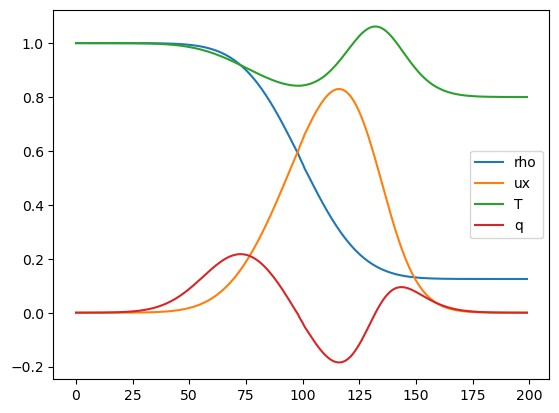

In [5]:
plt.plot(solver.dis.density().cpu()[0,:,0],label='rho')
plt.plot(solver.dis.velocity().cpu()[0,:,0],label='ux')
plt.plot(solver.dis.temperature().cpu()[0,:,0],label='T')
plt.plot(solver.dis.heatflux().cpu()[0,:,0],label='q')
plt.legend()
plt.show()

## Small Kn
Kn=1e-6

In [6]:
kn=1e-6
solver.set_initial(kn, f0)
for t in tqdm(range(100)):
    solver.solve_to(dt, max_dt)

100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


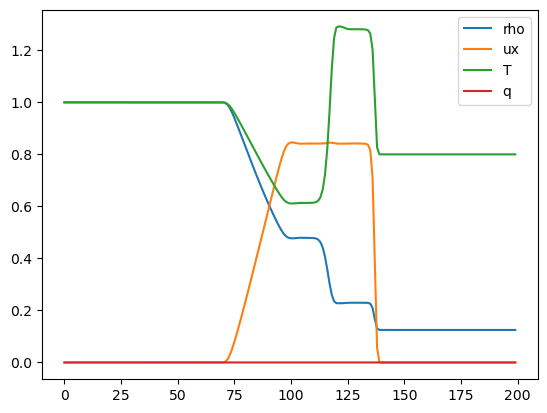

In [7]:
plt.plot(solver.dis.density().cpu()[0,:,0],label='rho')
plt.plot(solver.dis.velocity().cpu()[0,:,0],label='ux')
plt.plot(solver.dis.temperature().cpu()[0,:,0],label='T')
plt.plot(solver.dis.heatflux().cpu()[0,:,0],label='q')
plt.legend()
plt.show()